# Saves the Position Index (PI) for a set of Mapper graphs

Authors: Erik Amezquita and Kathleen Storey

Date: 2/10/2023

This code loops through Mapper parameter values and stores the position index (PI) for each resulting Mapper graph. 
It summarizes the PI sum for each subject in a figure. 

## Input
- A CSV file containing the T0 scores for each gene expression subject.

## Output
- A .png image of the PI summary graph.


In [2]:
# Load relevant packages
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy.spatial.distance as distance
import pandas as pd
import glob
import os
import math
import importlib
import matplotlib
import matplotlib.pyplot as plt
import colorsys
import mapper_tumor_utils as tumor
importlib.reload(tumor)
import gudhi as gd
import statmapper as stm
from sklearn_tda import MapperComplex

In [3]:
# Load data
# specify the cancer type and data type (T0, fpkm, etc.):
cancer_type = 'Lung'
data_type = 'T0'

# Enter path for the folder containing your data:
src = '/Users/storeyk/Documents/Research/Lung_Tumor_TDA/'
if data_type == 'T0':
    t0_scores = pd.read_csv(src + 'data/' + cancer_type + '_T0.csv')
    t0_scores = t0_scores.set_index('Hugo_Symbol')
elif data_type == 'fpkm':
    t0_scores = pd.read_csv(src + 'data/' + cancer_type + '_FPKM.csv')
    t0_scores = t0_scores.set_index('Hugo_Symbol')
    
t0_scores.sort_index(axis=1, inplace=True)

In [4]:
# Label tumor data vs. healthy data
labels = []

for person in t0_scores.columns:
    labels.append(person.split('-')[0] )

labels_int = np.array([1 if label == 'TCGA' else 0 for label in labels], dtype='uint8')

tumor_t0 = t0_scores.iloc[:, labels_int.astype(bool)]
health_t0 = t0_scores.iloc[:, ~labels_int.astype(bool)]
health_mean = health_t0.apply(np.mean, axis=1)
centered = t0_scores.sub(health_mean, axis='index')
col_diff = tumor_t0.sub(health_mean, axis='index')

In [5]:
# Compute the pairwise correlation between subjects
corr_t0, vals_t0 = tumor.explore_correlation(t0_scores)

In [9]:
data = np.array(t0_scores).T
data = np.nan_to_num(data)

In [16]:
#REMOVE
# Create the Mapper graph



# Choose filter function values
# filter function type (default = mean correlation):
val_ind = 1
# clustering scale parameter (epsilon):
eps = 600
# number of bins (b):
b = 80
# percent overlap between bins (p):
p = 0.5

if val_ind==0:
    filt_type="mincorr"
elif val_ind==1:
    filt_type="meancorr"
elif val_ind==2:
    filt_type="maxcorr"
elif val_ind==3:
    filt_type="diffcorr" 
    

params = {"filters": vals_t0[val_ind][:,np.newaxis], "filter_bnds": np.array([[np.nan,np.nan]]), 
          "colors": labels_int[:,np.newaxis], 
          "resolutions": np.array([b]), "gains": np.array([p]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None,linkage='single',distance_threshold=eps),
          "mask": 2}

M = MapperComplex(**params).fit(data)

In [17]:
#REMOVE
# Node information
G = stm.mapper2networkx(M)
subjects = 0
sett = set()

for node in G.nodes:
    subjects += M.node_info_[node]['size']
    sett = sett | set(M.node_info_[node]['indices'])

num_nodes=len(G.nodes)
print('Number of nodes: ', num_nodes)
print('Total distinct subjects', len(sett))

Number of nodes:  56
Total distinct subjects 807


In [18]:
#REMOVE
# Node intersection information
intersections = []

for edge in G.edges():
    subj0 = set(M.node_info_[edge[0]]['indices'])
    subj1 = set(M.node_info_[edge[1]]['indices'])
    intersection = subj0 & subj1
    intersections.append(len(intersection))
intersections = np.array(intersections)  

In [20]:
#REMOVE
# Save a matrix showing which subjects are in each node (subj vs node index)

subj_node_mat = np.zeros((t0_scores.shape[1], max(G.nodes)+1))

for node in G.nodes:
    node_list = M.node_info_[node]['indices']
    for subj in node_list:
        subj_node_mat[subj,node]=1
    
    
# save matrix to a .csv file
np.savetxt(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_r{}_g{}_subj_node_mat.csv'
               .format(eps,params['resolutions'][0], int(100*params['gains'][0])), subj_node_mat, fmt='%f', delimiter=",") 

In [93]:
#REMOVE
# Create matrices to store node and edge information
# diagonal matrix with the proportion of malignant cells in each node:
prop_mat = np.zeros((num_nodes, num_nodes))
# matrix with number of overlapping cells between nodes (diag=number of cells in node):
edge_mat = np.zeros((num_nodes, num_nodes))

node_ind=0
for node in G.nodes:
    M.node_info_[node]['index']=node_ind
    #store prop of malignant cells in diagonal entry
    prop_mat[node_ind,node_ind] = M.node_info_[node]["colors"][0]
    edge_mat[node_ind,node_ind] = M.node_info_[node]['size']    
    node_ind +=1
    
for edge in G.edges():
    subj0 = set(M.node_info_[edge[0]]['indices'])
    subj1 = set(M.node_info_[edge[1]]['indices'])
    intersection = subj0 & subj1
    edge_mat[M.node_info_[edge[0]]['index'], M.node_info_[edge[1]]['index']] = len(intersection)
    edge_mat[M.node_info_[edge[1]]['index'], M.node_info_[edge[0]]['index']] = len(intersection)
    
# save the matrices to .csv files

np.savetxt(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_r{}_g{}_prop_mat.csv'
           .format(eps,params['resolutions'][0], int(100*params['gains'][0])), prop_mat, fmt='%f', delimiter=",") 
np.savetxt(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_r{}_g{}_edge_mat.csv'
           .format(eps,params['resolutions'][0], int(100*params['gains'][0])), edge_mat, fmt='%d', delimiter=",") 




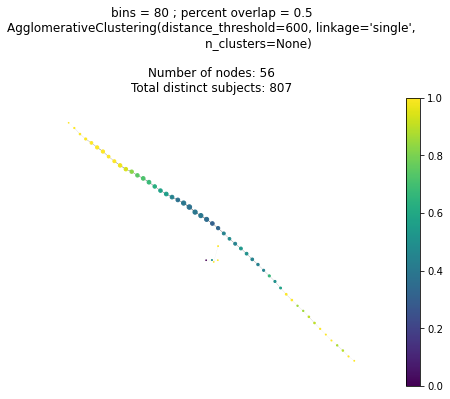

In [49]:
#REMOVE
# Draw and save the Mapper graph 
graph=nx.draw(G, pos=nx.kamada_kawai_layout(G), 
        node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()],
        node_size=[0.25*M.node_info_[node]['size'] for node in G.nodes()],
        linewidths=1,
        width = 0.01*intersections,
        node_shape='o',
        font_size=12)
vmin = min(M.node_info_[node]["colors"][0] for node in G.nodes())
vmax = max(M.node_info_[node]["colors"][0] for node in G.nodes())
cmap = [M.node_info_[node]["colors"][0] for node in G.nodes()]
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)


plt.title('bins = {} ; percent overlap = {}\n{}\n\nNumber of nodes: {}\nTotal distinct subjects: {}'
          .format(params['resolutions'][0], params['gains'][0], params['clustering'],len(G.nodes), len(sett)))


plt.savefig(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_b{}_p{}.png'
           .format(eps,params['resolutions'][0], int(100*params['gains'][0])), 
           dpi=150, format='png', bbox_inches='tight')


In [6]:
# functions used to determine which subjects are in the ends of the graph (used to compute PI)

def pick_sides(d, path, stretch=3):
    left,right = 0,0
    
    for i in range(stretch):
        left += d[path[i]]['size'] * d[path[i]]['colors']
    
    for i in range(len(path)-1,len(path)-stretch-1, -1):
        right += d[path[i]]['size'] * d[path[i]]['colors']
    
    if right < left:
        return np.array(path)
    else:
        return np.flip(np.array(path))
    
def count_subjects(L, patients, value=1):
    for i in range(len(patients)):
        L[patients[i]] += value
    return L

def track_subjects(d, comp, L, vals, stretch=3):
    leaves = [x for x in comp.nodes() if comp.degree(x) == 1]
    
    if len(leaves) == 2:
        
        path = nx.shortest_path(comp, source=leaves[0], target=leaves[1])
        st = min([stretch, math.floor(len(path)/2)])
        
        path = pick_sides(d, path, st)
                
        subjects = set()
        for i in range(st):
            sbj = set(d[path[i]]['indices'])
            #print(i, sbj)
            subjects |= sbj
        
        #print('\n', subjects,'\n')
        L = count_subjects(L, list(subjects), vals[0])

        subjects = set()
        for i in range(len(comp.nodes())-1,len(comp.nodes())-st-1, -1):
            sbj = set(d[path[i]]['indices'])
            #print(i, sbj)
            subjects |= sbj
        #print('\n', subjects)
        L = count_subjects(L, list(subjects), vals[1])
    
    return L

In [10]:
drawn = 0
resolutions = [80] 
stretch = [13] #length of the "ends" to calculate PI
gains = np.linspace(0.5, 0.5, 1) 
epsilon = [600,700,800,900,1000]
val_ind = 1  # determines filter function value
clust_method = 'AgClust'

num_comps = []


if val_ind==0:
    filt_type="mincorr"
elif val_ind==1:
    filt_type="meancorr"
elif val_ind==2:
    filt_type="maxcorr"
elif val_ind==3:
    filt_type="diffcorr"


main_comp = np.zeros(len(data), dtype=int)
satellite = np.zeros(len(data), dtype=int)

for r in range(len(resolutions)):
    for g in gains:
        for eps in epsilon:
            params = {"filters": vals_t0[val_ind][:,np.newaxis], "filter_bnds": np.array([[np.nan,np.nan]]), 
                      "colors": labels_int[:,np.newaxis], 
                      "resolutions": np.array([resolutions[r]]), "gains": np.array([g]), "inp": "point cloud", 
                      "clustering": AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=eps),
                      "mask": 2}
            M = MapperComplex(**params).fit(data)

            if M.mapper_.num_simplices() > 0:
                G = stm.mapper2networkx(M)

                subjects = 0
                sett = set()

                for node in G.nodes:
                    subjects += M.node_info_[node]['size']
                    sett |= set(M.node_info_[node]['indices'])

                intersections = []

                for edge in G.edges():
                    subj0 = set(M.node_info_[edge[0]]['indices'])
                    subj1 = set(M.node_info_[edge[1]]['indices'])
                    intersection = subj0 & subj1
                    intersections.append(len(intersection))

                conn_comps = [G.subgraph(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
                num_comps.append(len(conn_comps))

                main_comp = track_subjects(M.node_info_, conn_comps[0], main_comp, vals=[1,-1], stretch=stretch[r])

                for j in range(1,len(conn_comps),1):
                    satellite = track_subjects(M.node_info_, conn_comps[j], satellite, vals=[1,1], stretch=2)

                if drawn:
                    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
                            node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()],
                            node_size=[3*M.node_info_[node]['size'] for node in G.nodes()],
                            linewidths=1,
                            width = 0.2*np.array(intersections),
                            node_shape='o',
                            font_size=12)

                    plt.title('resol = {} ; gains = {}\n{}\n\nNumber of nodes: {}\nTotal distinct subjects: {}'
                              .format(params['resolutions'][0], params['gains'][0], params['clustering'],len(G.nodes), len(sett)))

                    plt.close()
                    
#                 function = params['filters']
#                 topo = "connected_components" 
#                 dgm, bnd = stm.compute_topological_features(M, function, "data", topo)


#                 function = params['filters']
#                 topo = "downbranch" 
#                 dgm, bnd = stm.compute_topological_features(M, function, "data", topo)


#                 function = params['filters']
#                 topo = "upbranch" 
#                 dgm, bnd = stm.compute_topological_features(M, function, "data", topo)


#                 function = params['filters']
#                 topo = "loop" 
#                 dgm, bnd = stm.compute_topological_features(M, function, "data", topo)
                


## We summarize the results as a couple of lists

- `main_comp` is a list representing the subjects present at the ends of the long line (connected component)
    - If a subject is on the left end, it gets a positive score
    - If a subject is on the right end, it gets a negative score
    - A high score (in absolute value) implies that a subject is consistently placed on the same end, even if mapper parameters change
    - _Make sure that patients aren't jumping from end to end when parameters change_
    
- `satellite`: list with subjects that end up in small connected components
    - Subjects here always get a positive score.

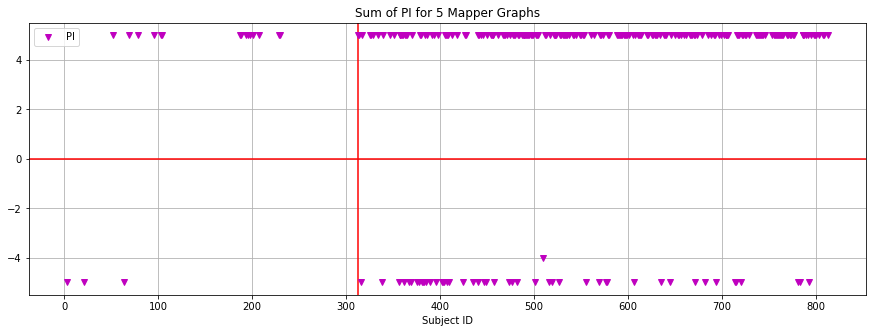

In [11]:
mean_corrAC_m = main_comp.copy()
mean_corrAC_s = satellite.copy()

plt.figure(figsize=(15,5))
plt.grid()
plt.axhline(0, c='r')
plt.axvline(len(data)-np.sum(labels_int),ymin=-1,ymax=1, c='r')
plt.title('Sum of PI for 5 Mapper Graphs')
plt.ylabel('')
plt.xlabel('Subject ID')

plt.plot(np.nonzero(mean_corrAC_m)[0], mean_corrAC_m[np.nonzero(mean_corrAC_m)[0]], 'v', c='m', label='PI')

plt.legend()
plt.savefig(src + 'data_viz/' + cancer_type + '/AgClust/endPlots/t0_' + filt_type + '+clusts.png', dpi=100, format='png', bbox_inches='tight')